In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [2]:
start_day_to_analyze = '2020-05-07'
end_day_to_analyze = '2020-05-08'

In [3]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [4]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [5]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [6]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [7]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,2855,539,ALLY,buy,557,15.09,"{'avg': 14.8197, 'rsi': 69.60586395878799, 'ma...",2020-05-07 14:35:49.618892+00:00,2020-05-07 14:35:49.746533,14.92,15.60
1,2857,539,ALLY,sell,557,15.20,"{'avg': 14.8391, 'rsi': [76.69472383045529, 79...",2020-05-07 14:41:41.357979+00:00,2020-05-07 14:41:41.586166,14.92,15.60
2,2846,539,FRO,buy,310,7.87,"{'avg': 7.7415, 'rsi': 74.76196926093641, 'mac...",2020-05-07 13:48:09.825050+00:00,2020-05-07 13:48:09.998768,7.60,8.81
3,2848,539,FRO,sell,259,7.87,"{'avg': 7.7462, 'rsi': [66.80648885612032, 68....",2020-05-07 13:51:23.863285+00:00,2020-05-07 13:51:24.036227,7.60,8.81
4,2849,539,FRO,sell,51,7.87,"{'avg': 7.7462, 'rsi': [66.80648885612032, 68....",2020-05-07 13:51:23.779925+00:00,2020-05-07 13:51:24.120174,7.60,8.81
5,2863,539,GPS,buy,677,7.72,"{'avg': 7.5328, 'rsi': 71.07031385200105, 'mac...",2020-05-07 14:44:13.371220+00:00,2020-05-07 14:44:13.599902,7.58,8.14
6,2872,539,GPS,sell,677,7.66,"{'avg': 7.5614, 'rsi': [46.78654651123863, 45....",2020-05-07 15:07:18.565961+00:00,2020-05-07 15:07:18.745267,7.58,8.14
7,2864,539,GT,buy,612,6.62,"{'avg': 6.4222, 'rsi': 69.35633038101003, 'mac...",2020-05-07 14:46:15.446332+00:00,2020-05-07 14:46:15.604437,6.47,7.09
8,2868,539,GT,sell,612,6.54,"{'avg': 6.4466, 'rsi': [43.26950913020842, 41....",2020-05-07 14:57:07.626384+00:00,2020-05-07 14:57:07.855912,6.47,7.09
9,2860,539,MOS,buy,498,11.45,"{'avg': 11.3201, 'rsi': 67.812954373279, 'macd...",2020-05-07 14:41:48.705086+00:00,2020-05-07 14:41:48.829835,11.26,12.02


In [8]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [9]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [10]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
1,539,momentum_long,PAPER,v0.1-372-gf0788c7,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-05-07 13:45:01.829263,None,None


,symbol,count,revenue
1,NCLH,5,-63.87
7,GT,2,-48.96
2,UNM,3,-48.15
4,GPS,2,-40.62
3,FRO,3,0.00
6,MOS,2,0.00
5,MT,2,5.91
8,ALLY,2,61.27
0,PENN,6,80.85


TOTAL REVENUE: -53.57 $


In [11]:

minute_history = {}
minute_history1 = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df
            minute_history1[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=20)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')-timedelta(days=11)).date()).df

In [12]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].between_time("9:30", "16:00").dropna().resample("5min").max()
        ).dropna()
        #print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

PENN analysis for run 539 with profit 80.85


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1147.30,-1147.30,buy,2020-05-07 13:48:25.483336,16.39,"[15.16, 15.5, 15.71, 15.75, 15.85, 15.8501]","[17.915, 17.925, 18.05]",70,"{'avg': 15.8158, 'rsi': 67.80418098301129, 'macd': [0.16238753572390152, 0.17146073208306767, 0.1742222308592467, 0.17834110048890928, 0.18835854990828693], 'vwap': 16.3596, 'supports': [15.16, 15.65], 'sell_macd': [0.10455155252127035, 0.10980219404412495, 0.11090915894447839, 0.11289758407534478, 0.11872625841010631], 'slow macd': [0.054338671344694944, 0.06043128015190824, 0.06546021567561588, 0.07077238671813646, 0.07731545589925126], 'macd_signal': [0.08170562666539696, 0.0996566477489311, 0.11456976437099423, 0.12732403159457722, 0.13953093525731916], 'resistances': [17.7871, 17.915, 17.925, 18.05], 'sell_macd_signal': [0.05285384666346055, 0.06424351613959343, 0.07357664470057043, 0.0814408325755253, 0.0888979177424415]}",20.42,15.06
1,-560.35,586.95,sell,2020-05-07 13:59:15.666241,16.77,None,None,35,"{'avg': 16.0085, 'rsi': [72.96918484693022, 74.17022283420941], 'vwap': 16.7011, 'reasons': 'scale-out', 'movement': 0.020134228187919358, 'sell_macd': [0.13153026831272996, 0.13307991155894072, 0.13203963471755742, 0.13107267049417715, 0.1306948714825289], 'sell_macd_signal': [0.12351539375727827, 0.12542829731761077, 0.1267505647976001, 0.1276149859369155, 0.12823096304603818]}",20.42,15.06
2,30.45,590.80,sell,2020-05-07 14:00:24.730340,16.88,None,None,35,"{'avg': 16.0443, 'rsi': [78.47419551688756, 79.09119106449101], 'vwap': 16.9296, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.009516994633273768, 'sell_macd': [0.13307991155894072, 0.13203963471755742, 0.13107267049417715, 0.14004552083317634, 0.146756241605992], 'sell_macd_signal': [0.12542829731761077, 0.1267505647976001, 0.1276149859369155, 0.13010109291616767, 0.13343212265413254]}",20.42,15.06
3,-2403.15,-2433.60,buy,2020-05-07 14:48:14.282074,16.90,"[15.16, 15.5, 15.71, 15.75, 15.85, 15.8501, 16.2601, 16.28]",[16.9],144,"{'avg': 16.2775, 'rsi': 70.04392692489336, 'macd': [0.03803531925496628, 0.06119742550828278, 0.07745038709697027, 0.0950052671211914, 0.10755675127553843], 'vwap': 16.9028, 'supports': [16.2601, 16.28], 'sell_macd': [0.024679176472339748, 0.03964806618468231, 0.05001800536073375, 0.06116317867504861, 0.06897548023588129], 'slow macd': [0.06276413801974456, 0.06695098478415318, 0.07045603495039288, 0.07471165122096934, 0.07848347306572023], 'macd_signal': [0.005798195899846552, 0.016878041821533796, 0.028992510876621094, 0.04219506212553516, 0.05526739995553581], 'resistances': [17.7871, 17.915, 17.925, 18.05], 'sell_macd_signal': [0.0031353491271562525, 0.010437892538661463, 0.01835391510307592, 0.02691576781747046, 0.03532771030115263]}",18.87,16.25
4,-1161.15,1242.00,sell,2020-05-07 14:59:11.852647,17.25,None,None,72,"{'avg': 16.3682, 'rsi': [78.32196800076431, 78.91225150005117], 'vwap': 17.2399, 'reasons': 'scale-out', 'movement': 0.020118343195266265, 'sell_macd': [0.08412195879036943, 0.08925849267122743, 0.09781087630993213, 0.10372947555684675, 0.10803319606668893], 'sell_macd_signal': [0.06793585119243843, 0.07220037948819623, 0.07732247885254341, 0.08260387819340408, 0.08768974176806105]}",18.87,16.25
5,80.85,1242.00,sell,2020-05-07 14:59:12.800129,17.25,None,None,72,"{'avg': 16.3699, 'rsi': [78.32196800076431, 79.73976763641211], 'vwap': 17.2496, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.0011594202898550477, 'sell_macd': [0.08412195879036943, 0.08925849267122743, 0.09781087630993213, 0.10372947555684675, 0.10959163762513313], 'sell_macd_signal': [0.06793585119243843, 0.07220037948819623, 0.07732247885254341, 0.08260387819340408, 0.08800143007974989]}",18.87,16.25


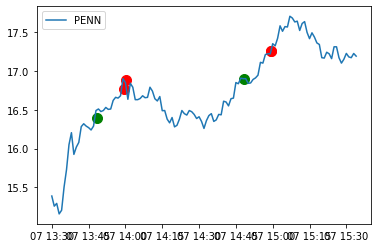

NCLH analysis for run 539 with profit -63.87


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3558.00,-3558.00,buy,2020-05-07 13:54:43.722533,11.86,"[11.12, 11.31, 11.35, 11.39, 11.45, 11.5739]",[12.32],300,"{'avg': 11.5609, 'rsi': 74.29235410895815, 'macd': [0.10716594537365332, 0.10824269534017361, 0.10785276787416898, 0.10990792136520078, 0.1150518972186827], 'vwap': 11.8623, 'supports': [11.45, 11.5739], 'sell_macd': [0.06395064366105352, 0.0644281749150597, 0.06396354764655676, 0.06510846733802644, 0.06827193115815788], 'slow macd': [0.05992454203065911, 0.06264858827510622, 0.06505460029244681, 0.06788387468298573, 0.07133794300521501], 'macd_signal': [0.10608050447059887, 0.10651294264451382, 0.10678090769044485, 0.10740631042539603, 0.10893542778405337], 'resistances': [12.52, 12.6114], 'sell_macd_signal': [0.06451049604971584, 0.06449403182278461, 0.06438793498753904, 0.06453204145763652, 0.0652800193977408]}",12.81,11.55
1,-87.00,3471.00,sell,2020-05-07 14:08:05.861189,11.57,None,None,300,"{'avg': 11.609, 'rsi': [43.66196152298165, 43.327060778089816], 'vwap': 11.5807, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.023608768971332156, 'sell_macd': [0.028435160790513336, 0.019796305622818977, 0.01150893399055164, 0.004122554355143748, -0.0019463460666706567], 'sell_macd_signal': [0.04487665018355231, 0.03986058127140564, 0.03419025181523484, 0.028176712323216623, 0.02215210064523917]}",12.81,11.55
2,-3242.37,-3155.37,buy,2020-05-07 14:41:46.005925,11.73,"[11.12, 11.31, 11.35, 11.39, 11.45, 11.57, 11.5739, 11.5748, 11.585]","[11.74, 11.8989]",269,"{'avg': 11.622, 'rsi': 59.72660342250978, 'macd': [0.0094646385689785, 0.01208177541640687, 0.013595694309218587, 0.016621178406900583, 0.019424379014406412], 'vwap': 11.741, 'supports': [11.45, 11.57, 11.5739, 11.5748, 11.585], 'sell_macd': [0.005691741177516363, 0.007395458393252952, 0.008367245075731944, 0.010314517229927489, 0.01210311219124982], 'slow macd': [0.03237206906826806, 0.03234243319574759, 0.032183472030034466, 0.032385589770767, 0.03264449843223893], 'macd_signal': [0.004985754692824772, 0.0064049588375411914, 0.00784310593187667, 0.009598720426881454, 0.011563852144386445], 'resistances': [11.8989], 'sell_macd_signal': [0.002514956173260431, 0.003491056617258935, 0.004466294308953537, 0.005635938893148328, 0.006929373552768627]}",12.11,11.62
3,-9130.83,-5888.46,buy,2020-05-07 14:41:46.313921,11.73,"[11.12, 11.31, 11.35, 11.39, 11.45, 11.57, 11.5739, 11.5748, 11.585]","[11.74, 11.8989]",502,"{'avg': 11.622, 'rsi': 59.72660342250978, 'macd': [0.0094646385689785, 0.01208177541640687, 0.013595694309218587, 0.016621178406900583, 0.019424379014406412], 'vwap': 11.741, 'supports': [11.45, 11.57, 11.5739, 11.5748, 11.585], 'sell_macd': [0.005691741177516363, 0.007395458393252952, 0.008367245075731944, 0.010314517229927489, 0.01210311219124982], 'slow macd': [0.03237206906826806, 0.03234243319574759, 0.032183472030034466, 0.032385589770767, 0.03264449843223893], 'macd_signal': [0.004985754692824772, 0.0064049588375411914, 0.00784310593187667, 0.009598720426881454, 0.011563852144386445], 'resistances': [11.8989], 'sell_macd_signal': [0.002514956173260431, 0.003491056617258935, 0.004466294308953537, 0.005635938893148328, 0.006929373552768627]}",12.11,11.62
4,-63.87,9066.96,sell,2020-05-07 14:51:05.900228,11.76,None,None,771,"{'avg': 11.6363, 'rsi': [55.98486708499683, 55.32629170913589], 'vwap': 11.7808, 'reasons': 'bail', 'movement': 0.004262574595055323, 'sell_macd': [0.02508050319097954, 0.024361041455735588, 0.022387940863911382, 0.02133892818373795, 0.019984646508488524], 'sell_macd_signal': [0.018416727529474992, 0.01960559031472711, 0.020162060424563966, 0.020397433976398763, 0.020314876482816716]}",12.11,11.62


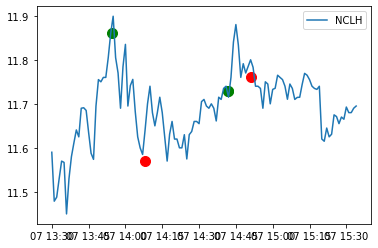

UNM analysis for run 539 with profit -48.15


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3228.76,-3228.76,buy,2020-05-07 14:44:07.695962,15.23,"[14.16, 14.225, 14.27, 14.27, 14.34, 14.45, 14.9, 14.97, 15.02, 15.05]","[15.235, 15.37, 15.6]",212,"{'avg': 14.9742, 'rsi': 71.58740706956273, 'macd': [0.026773145924735786, 0.03146957027655972, 0.03399275664591883, 0.04196399660315642, 0.04852876868813638], 'vwap': 15.2236, 'supports': [14.16, 14.225, 14.9, 14.97, 15.02, 15.05], 'sell_macd': [0.01639958182403589, 0.019423004347858708, 0.02100719067359158, 0.026124645074506958, 0.030292471295030765], 'slow macd': [0.05246163224342126, 0.052911275058454166, 0.05308040061509267, 0.0544305950586601, 0.05574569903083848], 'macd_signal': [0.012208405945813109, 0.01606063881196243, 0.01964706237875371, 0.02411044922363425, 0.028994113116534676], 'resistances': [15.37], 'sell_macd_signal': [0.006618502160797589, 0.009179402598209813, 0.011544960213286166, 0.014460897185530324, 0.017627212007430414]}",16.12,14.94
1,-4888.83,-1660.07,buy,2020-05-07 14:44:07.761614,15.23,"[14.16, 14.225, 14.27, 14.27, 14.34, 14.45, 14.9, 14.97, 15.02, 15.05]","[15.235, 15.37, 15.6]",109,"{'avg': 14.9742, 'rsi': 71.58740706956273, 'macd': [0.026773145924735786, 0.03146957027655972, 0.03399275664591883, 0.04196399660315642, 0.04852876868813638], 'vwap': 15.2236, 'supports': [14.16, 14.225, 14.9, 14.97, 15.02, 15.05], 'sell_macd': [0.01639958182403589, 0.019423004347858708, 0.02100719067359158, 0.026124645074506958, 0.030292471295030765], 'slow macd': [0.05246163224342126, 0.052911275058454166, 0.05308040061509267, 0.0544305950586601, 0.05574569903083848], 'macd_signal': [0.012208405945813109, 0.01606063881196243, 0.01964706237875371, 0.02411044922363425, 0.028994113116534676], 'resistances': [15.37], 'sell_macd_signal': [0.006618502160797589, 0.009179402598209813, 0.011544960213286166, 0.014460897185530324, 0.017627212007430414]}",16.12,14.94
2,-48.15,4840.68,sell,2020-05-07 14:59:24.524586,15.08,None,None,321,"{'avg': 15.0069, 'rsi': [46.88247771535193, 45.60832478432821], 'vwap': 15.086, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.00919238345370982, 'sell_macd': [0.01408636137060526, 0.00687660349986885, 0.00402644667202523, 0.0017532537325113395, -0.0005603154896114404], 'sell_macd_signal': [0.02278421190018795, 0.01960269022012413, 0.01648744151050435, 0.013540603954905747, 0.010720420066002309]}",16.12,14.94


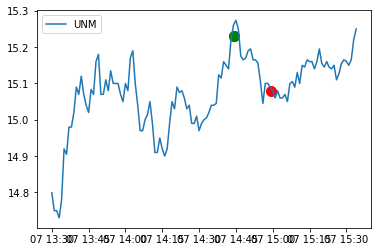

FRO analysis for run 539 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2439.70,-2439.70,buy,2020-05-07 13:48:09.998768,7.87,"[7.625, 7.73, 7.77, 7.78, 7.83, 7.86, 7.86]","[7.885, 7.895]",310,"{'avg': 7.7415, 'rsi': 74.76196926093641, 'macd': [0.0902465250013531, 0.08985320199250157, 0.09011651642154828, 0.09368331243950223, 0.09580107783887293], 'vwap': 7.8999, 'supports': [7.625], 'sell_macd': [0.05678890407131476, 0.05619384555723084, 0.05603933443512332, 0.05804829545120693, 0.05911439110723027], 'slow macd': [0.025962731757991797, 0.028482041177580797, 0.03107420543578243, 0.03428902876100359, 0.037270297196146274], 'macd_signal': [0.06617624589356982, 0.07091163711335617, 0.0747526129749946, 0.07853875286789612, 0.08199121786209149], 'resistances': [8.23, 8.37], 'sell_macd_signal': [0.04217475939945249, 0.04497857663100816, 0.04719072819183119, 0.04936224164370634, 0.05131267153641113]}",8.81,7.6
1,-401.37,2038.33,sell,2020-05-07 13:51:24.036227,7.87,None,None,259,"{'avg': 7.7462, 'rsi': [66.80648885612032, 68.868066942545], 'vwap': 7.875, 'reasons': 'bail', 'movement': 0.0006353240152477628, 'sell_macd': [0.05804829545120693, 0.05834036513320395, 0.056511583520043374, 0.053833161697840026, 0.05234564908706041], 'sell_macd_signal': [0.04936224164370634, 0.051157866341605865, 0.052228609777293364, 0.0525495201614027, 0.05250874594653424]}",8.81,7.6
2,0.00,401.37,sell,2020-05-07 13:51:24.120174,7.87,None,None,51,"{'avg': 7.7462, 'rsi': [66.80648885612032, 68.868066942545], 'vwap': 7.875, 'reasons': 'bail', 'movement': 0.0006353240152477628, 'sell_macd': [0.05804829545120693, 0.05834036513320395, 0.056511583520043374, 0.053833161697840026, 0.05234564908706041], 'sell_macd_signal': [0.04936224164370634, 0.051157866341605865, 0.052228609777293364, 0.0525495201614027, 0.05250874594653424]}",8.81,7.6


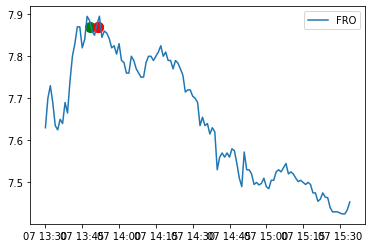

GPS analysis for run 539 with profit -40.62


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5226.44,-5226.44,buy,2020-05-07 14:44:13.599902,7.72,"[7.15, 7.17, 7.17, 7.17, 7.17, 7.18, 7.1999, 7.2, 7.25, 7.27, 7.3, 7.33, 7.38, 7.4949, 7.52, 7.54, 7.59]","[7.84, 7.845, 7.85]",677,"{'avg': 7.5328, 'rsi': 71.07031385200105, 'macd': [0.022308400128900452, 0.023572284382382236, 0.024293877066650538, 0.026975536553565327, 0.0303645798945551], 'vwap': 7.72, 'supports': [7.4949, 7.52, 7.54, 7.59], 'sell_macd': [0.013120472104608538, 0.013932128076576511, 0.014383650547244997, 0.01610712714065876, 0.01827987348435034], 'slow macd': [0.03621738074573688, 0.03632203413523527, 0.03636022658333449, 0.036817019832732, 0.03749827260663441], 'macd_signal': [0.017308793773454064, 0.018561491895239698, 0.019707968929521865, 0.021161482454330558, 0.023002101942375466], 'resistances': [7.82], 'sell_macd_signal': [0.009756057912524973, 0.01059127194533528, 0.011349747665717223, 0.01230122356070553, 0.013496953545434492]}",8.14,7.58
1,-40.62,5185.82,sell,2020-05-07 15:07:18.745267,7.66,None,None,677,"{'avg': 7.5614, 'rsi': [46.78654651123863, 45.59640521245431], 'vwap': 7.6693, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.007772020725388551, 'sell_macd': [0.0034998461926400992, 0.0028296316148530565, 0.0025303782865142566, 0.0012253707801912483, -6.717235175113245e-05], 'sell_macd_signal': [0.007463630386072247, 0.006536830631828409, 0.005735540162765578, 0.004833506286250712, 0.003853370558650343]}",8.14,7.58


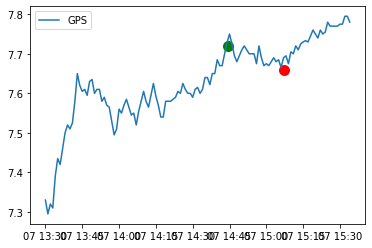

MT analysis for run 539 with profit 5.91


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-6577.83,-6577.83,buy,2020-05-07 14:22:15.478782,11.13,"[10.445, 10.45, 10.54, 10.61, 10.61, 10.61, 10.61, 10.65, 10.66, 10.73, 10.95, 11.0, 11.0]",[11.79],591,"{'avg': 10.9783, 'rsi': 72.72697725798255, 'macd': [0.023238437593052552, 0.027419306982398695, 0.029983585769123522, 0.03244866361320575, 0.035605648663548095], 'vwap': 11.1228, 'supports': [10.45, 10.95, 11.0, 11.0], 'sell_macd': [0.011144673871884336, 0.014027683054683493, 0.015832265754857744, 0.017552300771162876, 0.019703596877748808], 'slow macd': [0.06694930477955552, 0.06699046510173723, 0.06684122401454573, 0.06675695026897088, 0.06689251936547436], 'macd_signal': [0.026997476078101434, 0.027081842258960886, 0.027662190960993413, 0.02861948549143588, 0.030016718125858325], 'resistances': [11.79], 'sell_macd_signal': [0.012867345927155032, 0.013099413352660724, 0.013645983833100127, 0.014427247220712678, 0.015482517152119905]}",11.61,10.97
1,5.91,6583.74,sell,2020-05-07 14:39:32.980438,11.14,None,None,591,"{'avg': 10.9936, 'rsi': [60.70266507319475, 62.70316307909515], 'vwap': 11.14, 'reasons': 'bail', 'movement': 0.0008984725965857849, 'sell_macd': [0.016167849423226244, 0.015827815812558654, 0.0158767790274581, 0.015189259727023341, 0.014975747808152917], 'sell_macd_signal': [0.014752508247103512, 0.014967569760194541, 0.015149411613647253, 0.01515738123632247, 0.015121054550688559]}",11.61,10.97


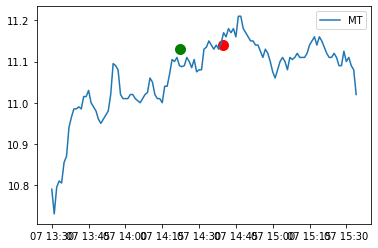

MOS analysis for run 539 with profit 0.0


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-5702.1,-5702.1,buy,2020-05-07 14:41:48.829835,11.45,"[10.74, 10.75, 10.79, 10.8, 11.0, 11.01, 11.12, 11.13, 11.24, 11.27, 11.29]",[11.57],498,"{'avg': 11.3201, 'rsi': 67.812954373279, 'macd': [0.008537458653425034, 0.010824264588528365, 0.010498266223285313, 0.01650498241891185, 0.022618449724101097], 'vwap': 11.45, 'supports': [10.8, 11.24, 11.27, 11.29], 'sell_macd': [0.005724973778534093, 0.00718357110194745, 0.006928146014971048, 0.010794981713235785, 0.014706866910414007], 'slow macd': [0.02599925233992373, 0.02600305990784335, 0.02556513466760002, 0.026400829782964763, 0.027447343633955512], 'macd_signal': [-0.0007516102563905193, 0.0015635647125932578, 0.0033505050147316687, 0.005981400495567705, 0.009308810341274384], 'resistances': [11.57], 'sell_macd_signal': [-0.0005405315490101318, 0.0010042889811813847, 0.0021890603879393174, 0.003910244652998611, 0.006069569104481691]}",12.02,11.26
1,0.0,5702.1,sell,2020-05-07 14:52:31.558298,11.45,None,None,498,"{'avg': 11.3314, 'rsi': [61.13876425493922, 58.29588014187088], 'vwap': 11.4502, 'reasons': 'bail', 'movement': 0.0004366812227074919, 'sell_macd': [0.020148844339095362, 0.01879920561919768, 0.018282614335911163, 0.018941340422493624, 0.01842942126369529], 'sell_macd_signal': [0.01880475259184798, 0.01880364319731792, 0.018699437425036568, 0.01874781802452798, 0.01868413867236144]}",12.02,11.26


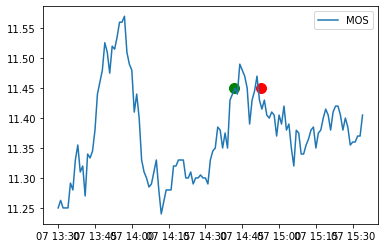

GT analysis for run 539 with profit -48.96


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-4051.44,-4051.44,buy,2020-05-07 14:46:15.604437,6.62,"[6.1, 6.135, 6.155, 6.16, 6.16, 6.2396, 6.24, 6.3, 6.34, 6.4801]",[6.745],612,"{'avg': 6.4222, 'rsi': 69.35633038101003, 'macd': [0.03366578070146353, 0.033903081485929576, 0.032904920203264076, 0.03414106255783356, 0.03511933861844607], 'vwap': 6.6209, 'supports': [6.135, 6.155, 6.16, 6.3, 6.34, 6.4801], 'sell_macd': [0.01916377254477819, 0.01932113403628488, 0.01867334904218243, 0.019484512046230584, 0.020123281763070544], 'slow macd': [0.04208988417003301, 0.042325043780161664, 0.04231376912513696, 0.04271552919802346, 0.043096811809346214], 'macd_signal': [0.03433589503296427, 0.03424933232355733, 0.03398044989949868, 0.03401257243116566, 0.03423392566862174], 'resistances': [6.745, 6.745], 'sell_macd_signal': [0.019621023216870558, 0.01956104538075342, 0.019383506113039222, 0.019403707299677494, 0.019547622192356104]}",7.09,6.47
1,-48.96,4002.48,sell,2020-05-07 14:57:07.855912,6.54,None,None,612,"{'avg': 6.4466, 'rsi': [43.26950913020842, 41.407397335478926], 'vwap': 6.532, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.013293051359516628, 'sell_macd': [0.007972865211213431, 0.005380658330865096, 0.003389579484737837, 0.0011758871437983487, -0.0009799236042553616], 'sell_macd_signal': [0.014449094531500265, 0.01263540729137323, 0.010786241730046152, 0.008864170812796592, 0.006895351929386201]}",7.09,6.47


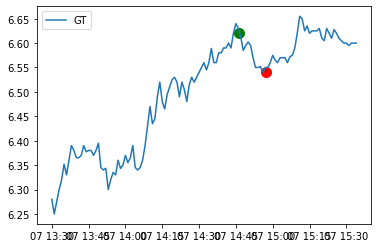

ALLY analysis for run 539 with profit 61.27


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-8405.13,-8405.13,buy,2020-05-07 14:35:49.746533,15.09,"[14.05, 14.1, 14.17, 14.17, 14.17, 14.23, 14.3, 14.35, 14.4, 14.84, 14.88, 14.95]","[15.165, 15.2498]",557,"{'avg': 14.8197, 'rsi': 69.60586395878799, 'macd': [0.019530856370359118, 0.022247443095709585, 0.024122290893682674, 0.028507174030057314, 0.03401091809382706], 'vwap': 15.0759, 'supports': [14.17, 14.84, 14.88, 14.95], 'sell_macd': [0.010196396951039688, 0.012050116057608307, 0.013338077490551825, 0.016246384094266375, 0.01986004658944296], 'slow macd': [0.061290477253772124, 0.06096519632557573, 0.06056842215481062, 0.06074625060121264, 0.06129251139800118], 'macd_signal': [0.0191494500843085, 0.019769048686588717, 0.02063969712800751, 0.02221319250841747, 0.02457273762549939], 'resistances': [15.2498], 'sell_macd_signal': [0.009398665814394004, 0.009928955863036864, 0.010610780188539856, 0.01173790096968516, 0.013362330093636719]}",15.6,14.92
1,61.27,8466.40,sell,2020-05-07 14:41:41.586166,15.20,None,None,557,"{'avg': 14.8391, 'rsi': [76.69472383045529, 79.25331063202783], 'vwap': 15.215, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.00828363154406892, 'sell_macd': [0.023202481407638587, 0.025995174206492777, 0.028353179319802635, 0.03232625889744867, 0.03691403182941322], 'sell_macd_signal': [0.016696145028225598, 0.018555950863879032, 0.020515396555063754, 0.022877569023540736, 0.02568486158471523]}",15.6,14.92


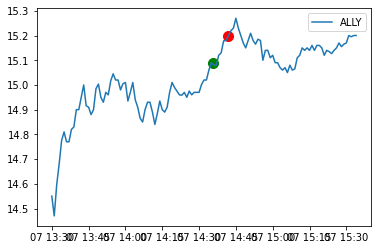

In [13]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))